# Learning compositional communication protocols from end-to-end reference games

## Setup

In [137]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from collections import Counter
from tqdm import tqdm, trange

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

random = np.random.RandomState()

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("white")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
def lzip(*args):
    return list(zip(*args))

def load_continuous_messages(filepath, proj=sklearn.decomposition.PCA):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    df = pd.read_pickle(filepath)

    msgs_proj = proj(2).fit_transform(np.vstack(df.msg))
    
    df['x'] = msgs_proj[:, 0]
    df['y'] = msgs_proj[:, 1]
    df['relation_pair'] = pd.Series(lzip(df.relation_dir, df.relation), dtype='category')
    # These group unique
    df['target'] = pd.Series(lzip(df.target_shape, df.target_color), dtype='category')
    df['distractor'] = pd.Series(lzip(df.distractor_shape, df.distractor_color), dtype='category')
    df['config'] = pd.Series(lzip(df.target_shape, df.target_color, df.distractor_shape, df.distractor_color),
                            dtype='category')
    
    return df

def plot2d(df, hue='relation_pair', alpha=0.3):
    """Plot PCA-reduced messages, colored by relation or other factor"""
    sns.lmplot('x', 'y', data=df, fit_reg=False, hue=hue, legend_out=True,
           scatter_kws={'s': 10, 'alpha': alpha})
    
def load_discrete_messages(filepath):
    """
    Preprocess continuous messages. Does PCA reduction to two dimensions.
    """
    df = pd.read_pickle(filepath)
    
    msg_arr = np.vstack(df.msg)
    
    # Must be one-hot
    assert np.all(msg_arr.sum(axis=1) == 1)
    # Turn into unique counts
    df['tokens'] = np.argwhere(msg_arr)[:, 1]

    return df

Further analysis functions

In [150]:
def _classify(model, X_train, y_train, X_test, y_test):
    clf = model()
    clf.fit(X_train, y_train)
    
    print("Accuracy on test split: {}".format(clf.score(X_test, y_test)))
    
    return clf, X_train, y_train, X_test, y_test


def _rm_categorical(*arrs):
    new_arrs = []
    for arr in arrs:
        if arr.dtype.name == 'category':
            new_arrs.append(LabelEncoder().fit_transform(arr))
        else:
            new_arrs.append(arr)
    return new_arrs


def make_train_test(df, x_feats, y_feat, test_size=0.1):
    # Convert pd.Categorical to numerics
    x_feats_df = _rm_categorical(*(df[xf] for xf in x_feats))
    y_feats_df, = _rm_categorical(df[y_feat])
            
    data_pairs = lzip(lzip(*x_feats_df), y_feats_df)
    train, test = train_test_split(data_pairs, test_size=0.1)
    X_train, y_train = zip(*train)
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test, y_test = zip(*test)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    print("{} train, {} test".format(len(X_train), len(X_test))) 
    return X_train, y_train, X_test, y_test


def classify(df, x_feats, y_feat, model=sklearn.linear_model.LogisticRegression,
            test_size=0.1):
    return _classify(model, *make_train_test(df, x_feats, y_feat, test_size=test_size))

def plot_dimension_histograms(df):
    indices_x = Counter()
    indices_y = Counter()
    indices = Counter()
    
    # Init all values
    for i in range(df.msg[0].shape[0]):
        indices_x[i] = 0
        indices[i] = 0
        indices_y[i] = 0

    for msg, rel in zip(df.msg, df.relation):
        msg_nonzero = np.argwhere(msg).squeeze()
        for i in msg_nonzero:
            indices[i] += 1
            if rel == 0:
                indices_x[i] += 1
            else:
                indices_y[i] += 1
                
    n_nonzero = len({x: v for x, v in indices.items() if v != 0}.keys())
    print("{} out of {} dimensions are ever nonzero".format(n_nonzero, len(indices.items())))

    indexes, counts = zip(*indices_x.items())
    idx_df = pd.DataFrame({'indexes': indexes, 'counts': counts}).sort_values('indexes')
    sns.barplot(idx_df.indexes, idx_df.counts)
    plt.title('X Messages')
    plt.show()

    indexes, counts = zip(*indices_y.items())
    idx_df = pd.DataFrame({'indexes': indexes, 'counts': counts}).sort_values('indexes')
    sns.barplot(idx_df.indexes, idx_df.counts)
    plt.title('Y Messages')
    plt.show()
    
    return indices_x, indices_y

def kmeans_scree(msgs, min_k=60, max_k=80):
    xy = np.array(lzip(msgs.x, msgs.y))
    best_kmeans = None
    best_kmeans_error = 1e100
    km_res = {'k': [], 'err': []}
    for k in trange(60, 80, desc='k'):
        km = KMeans(k)
        km.fit(xy)
        km_res['k'].append(k)
        km_res['err'].append(km.inertia_)
    plt.plot(km_res['k'], km_res['err'], marker='o')
    plt.xticks(km_res['k'])
    plt.title('KMeans WSS Cluster')
    plt.xlabel('$k$')
    plt.ylabel('WSS')
    plt.show()
    
def kmeans(msgs, k):
    xy = np.array(lzip(msgs.x, msgs.y))
    km = KMeans(k)
    return km.fit_predict(xy)

## Analysis: Feature-based models

With a model that gets clean indicators for image features (i.e. the Shapeworld World data), messages show clean relational structure in both continuous and discrete forms.

TODO: Simple experiments that verify this.

However, this isn't inherently interesting, as it has already been established in Andreas and Klein (2017). We're thus interested in whether these kinds of abstract, compositional relationships can be learned from referenatial games where the agents are only given raw pixel input. This makes the game considerably more challenging, as object recognition must be learned only from reward signals given by the reference game. This also differs from Lazaridou et al. (2017), which uses independently pre-trained convolutional neural networks to extract image representations from images.

## Analysis: End to end models

### Symmetric Game, Continuous

The following is an 8 pick 4 game, where speaker and listener see the same images:

Exact accuracy: 1.0


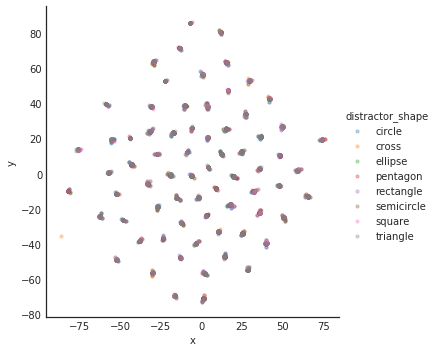

In [151]:
msgs = load_continuous_messages('data/500_400-end2end-gru-continuous64-30epochs-msgs.pkl',
                                 proj=TSNE)
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='distractor_shape')

What are properties of the messages in a single cluster? We'll do cluster analysis to find out:

k: 100%|██████████| 20/20 [00:04<00:00,  4.16it/s]


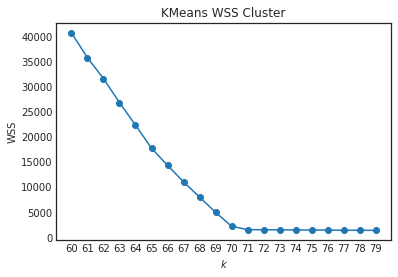

In [152]:
kmeans_scree(msgs)

In [177]:
msgs['cluster'] = kmeans(msgs, 71)

An SVM trained on world features to predict clusters given world features:

In [178]:
clf, X_train, y_train, X_test, y_test = classify(msgs,
         ['relation', 'relation_dir', 'target_shape', 'target_color', 'distractor_shape', 'distractor_color'],
         'cluster', model=sklearn.svm.SVC)

3340 train, 372 test
Accuracy on test split: 0.005376344086021506


Within clusters, messages have odd shapes, often with circles (probably just an artefact of t-SNE):

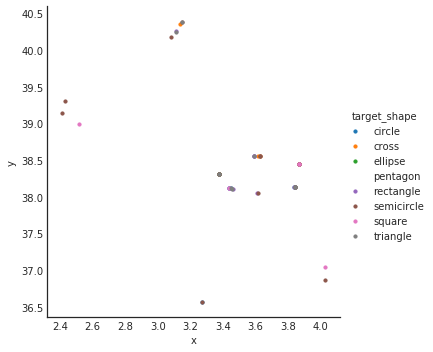

In [182]:
# TODO: Remove unused categories
plot2d(msgs[msgs.cluster == 1], hue='target_shape', alpha=1)

There doesn't seem to be any rhyme or reason to the messages looped into one cluster:

In [189]:
msgs[msgs.cluster == 0].drop(
    columns=['msg', 'pred', 'obs', 'cluster', 'target_shape', 'target_color', 'distractor_shape', 'distractor_color',
             'relation_pair']
).head(10)

,relation,relation_dir,correct,x,y,target,distractor,config
21,y,True,True,-76.077202,13.903183,"(cross, green)","(circle, red)","(cross, green, circle, red)"
84,x,False,True,-75.690109,13.973151,"(rectangle, blue)","(cross, blue)","(rectangle, blue, cross, blue)"
235,y,True,True,-75.690109,13.973151,"(cross, green)","(circle, red)","(cross, green, circle, red)"
353,x,False,True,-76.060959,13.929795,"(square, cyan)","(pentagon, cyan)","(square, cyan, pentagon, cyan)"
438,y,True,True,-76.012390,13.646021,"(cross, red)","(square, cyan)","(cross, red, square, cyan)"
493,x,False,True,-75.824081,13.588665,"(ellipse, green)","(rectangle, magenta)","(ellipse, green, rectangle, magenta)"
689,y,False,True,-75.710907,13.997115,"(rectangle, blue)","(circle, cyan)","(rectangle, blue, circle, cyan)"
788,x,True,True,-75.824081,13.588665,"(square, cyan)","(circle, yellow)","(square, cyan, circle, yellow)"
800,x,False,True,-75.988953,13.626916,"(square, cyan)","(pentagon, cyan)","(square, cyan, pentagon, cyan)"
836,x,False,True,-75.903145,14.052689,"(ellipse, green)","(rectangle, magenta)","(ellipse, green, rectangle, magenta)"


In [190]:
_ = plot_dimension_histograms(npzs)

AttributeError: 'dict' object has no attribute 'msg'

In [6]:
_ = classify_relations_from_msgs(npzs, model=sklearn.svm.SVC)

2784 train, 928 test
Accuracy on test split: 0.4709051724137931


In [27]:
sklearn.manifold.TSNE(2).fit_transform(np.array(x.msg))

ValueError: setting an array element with a sequence.

### Asymmetric Game, Continuous

Exact accuracy: 0.8116629464285714


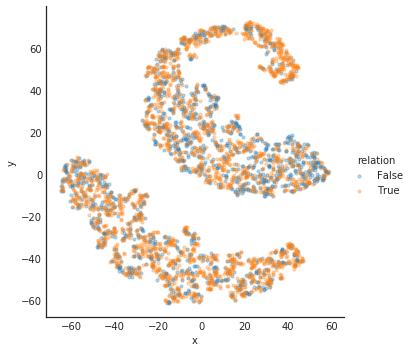

In [7]:
msgs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='tsne')
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

Exact accuracy: 0.8116629464285714


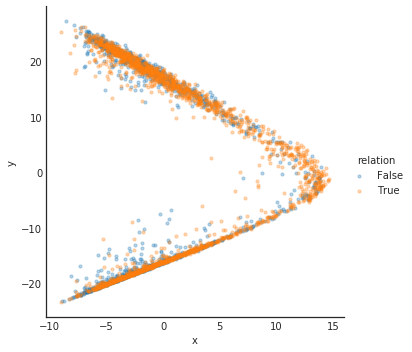

In [8]:
msgs, npzs = load_continuous_messages('data/500_500_asymTrue-end2end-gru-continuous64-30epochs-msgs.npz',
                               proj='pca', return_orig=True)
print("Exact accuracy: {}".format(msgs.correct.mean()))
plot2d(msgs, hue='relation')

32 out of 64 dimensions are ever nonzero


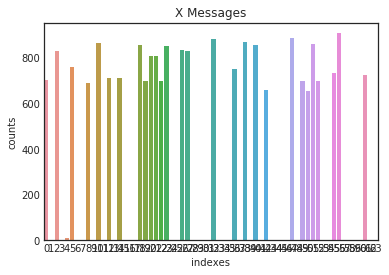

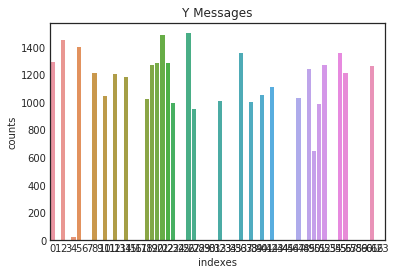

In [9]:
_ = plot_dimension_histograms(npzs)

In [10]:
_ = classify_relations_from_msgs(npzs, model=sklearn.svm.SVC)

2688 train, 896 test
Accuracy on test split: 0.6361607142857143


However, this isn't too interesting - we want to explore structure emerging from end-to-end models which have to process raw image data.